<img src="qiskit-heading.gif" width="500 px" align="center">

## Grover Search for Combinatorial Problems

This notebook is based on an official notebook by Qiskit team, available at https://github.com/qiskit/qiskit-tutorial under the [Apache License 2.0](https://github.com/Qiskit/qiskit-tutorial/blob/master/LICENSE) license. 
Initially done by Giacomo Nannicini and Rudy Raymond (based on [this paper](https://arxiv.org/abs/1708.03684)).


### Introduction

Grover search is one of the most popular algorithms used for searching a solution among many possible candidates using Quantum Computers. If there are $N$ possible solutions among which there is exactly one solution (that can be verified by some function evaluation), then Grover search can be used to find the solution with $O(\sqrt{N})$ function evaluations. This is in contrast to classical computers that require $\Omega(N)$ function evaluations: the Grover search is a quantum algorithm that provably can be used search the correct solutions quadratically faster than its classical counterparts.  

Here, we are going to illustrate the use of Grover search to solve a combinatorial problem called [Exactly-1 3-SAT problem](https://en.wikipedia.org/wiki/Boolean_satisfiability_problem#Exactly-1_3-satisfiability). The Exactly-1 3-SAT problem is a NP-complete problem, namely, it is one of the most difficult problems that are interconnected (meaning that if we solve any one of them, we essentially can solve all of them). Unfortunately, there are many natural problems that are NP-complete, such as, the Traveling Salesman Problem (TSP), the Maximum Cut (MaxCut) and so on. Up to now, there is no classical and quantum algorithm that can efficiently solve such NP-hard problems. 

We begin with an example of the Exactly-1 3-SAT problem. Then, we show how to design an evaluation function which is also known as the oracle (or, blackbox) which is essential to Grover search. Finally, we show the circuit of Grover search using the oracle and present their results on simulator and real-device backends.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister


from qiskit.tools import visualization
from qiskit.tools.visualization import circuit_drawer

from qiskit import execute


In [2]:
# Plot results
def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()


# Execute circuit, display a histogram of the results
def execute_locally(qc, draw_circuit=False):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_sim, "\n\n", result_counts)
    
    if draw_circuit: # draw the circuit
        qc.draw()
    else: # or show the results
        show_results(result_counts)

### State Initialization

**Task**: Begin by implementing a function for state initialization, i.e. implementing the circuit below for an arbitrary number of qubits.


<img src="img/init.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="400 px" align="center"> 

In [3]:
# We call f in the input register, of size n, and f out the output register, of size 1

def input_state(circuit, f_in, f_out):
    circuit.x(f_out)
    circuit.h(f_out)
    circuit.h(f_in)

## Exactly-1 3-SAT problem

The Exactly-1 3-SAT problem is best explained with the following concrete problem. Let us consider a Boolean function $f$ with three Boolean variables $x_1, x_2, x_3$ as below.

$$
f(x_1, x_2, x_3) = (x_1 \vee x_2 \vee \neg x_3) \wedge (\neg x_1 \vee \neg x_2 \vee \neg x_3) \wedge (\neg x_1 \vee x_2 \vee x_3) 
$$

In the above function, the terms on the right-hand side equation which are inside $()$ are called clauses. Each clause has exactly three literals. Namely, the first clause has $x_1$, $x_2$ and $\neg x_3$ as its literals. The symbol $\neg$ is the Boolean NOT that negates (or, flips) the value of its succeeding literal. The symbols $\vee$ and $\wedge$ are, respectively, the Boolean OR and AND. The Boolean $f$ is satisfiable if there is an assignment of $x_1, x_2, x_3$ that evaluates to $f(x_1, x_2, x_3) = 1$ (or, $f$ evaluates to True). The Exactly-1 3-SAT problem requires us to find an assignment such that $f = 1$ (or, True) and there is *exactly* one literal that evaluates to True in every clause of $f$. 

A naive way to find such an assignment is by trying every possible combinations of input values of $f$. Below is the table obtained from trying all possible combinations of $x_1, x_2, x_3$. For ease of explanation, we interchangably use $0$ and False, as well as $1$ and True.  

|$x_1$ | $x_2$ | $x_3$ | $f$ | Comment | 
|------|-------|-------|-----|---------|
| 0    |  0    |  0    |  1  | Not a solution because there are three True literals in the second clause     | 
| 0    |  0    |  1    |  0  | Not a solution because $f$ is False          | 
| 0    |  1    |  0    |  1  | Not a solution because there are two True literals in the first clause        | 
| 0    |  1    |  1    |  1  | Not a solution because there are three True literals in the third clause        | 
| 1    |  0    |  0    |  0  | Not a solution because $f$ is False        | 
| 1    |  0    |  1    |  1  | **Solution**. BINGO!!       | 
| 1    |  1    |  0    |  1  | Not a solution because there are three True literals in the first clause        | 
| 1    |  1    |  1    |  0  | Not a solution because $f$ is False        | 


From the table above, we can see that the assignment $x_1x_2x_3 = 101$ is the solution fo the Exactly-1 3-SAT problem to $f$. In general, the Boolean function $f$ can have many clauses and more Boolean variables. 

## A blackbox function to check the assignment of Exactly-1 3-SAT problem

Here, we describe a method to construct a circuit to check the assignment of Exactly-1 3-SAT problem. The circuit can then be used as a blackbox (or, oracle) in Grover search. To design the blackbox, we do not need to know the solution to the problem in advance: it suffices to design a blackbox that checks if the assignment results in $f$ evaluates to True or False. It turns out that we can design such a blackbox efficiently (in fact, any NP-complete problem has the property that although finding the solution is difficult, checking the solution is easy). 

For each clause of $f$, we design a sub-circuit that outputs True if and only if there is exactly one True literal in the clause. Combining all sub-circuits for all clauses, we can then obtain the blackbox that outputs True if and only if all clauses are satisfied with exactly one True literal each.   

For example, let us consider the clause $(x_1 \vee \neg x_2 \vee x_3)$. It is easy to see that $y$ defined as 

$$
y = x_1 \oplus \neg x_2 \oplus x_3 \oplus ( x_1 \wedge \neg x_2 \wedge x_3), 
$$

Note that this clause can be written as [1, -2, 3]

is True if and only if exactly one of $x_1$, $\neg x_2$, and $x_3$ is True. Using two working qubits, $y$ can be computed by the following sub-circuit. Below, $x_1x_2x_3$ is renamed as $q_1q_2q_3$, $q_4$ is used as a working qubit, and $q_5$ is used to store the value of $y$.  

## Blackbox

Implement the circuit below, for the blackbox:

<img src="img/black_box1.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="400 px" align="center"> 

Keep in mind that a CCNOT can be decomposed using an ancilla qubit (q4):

<img src="img/cccnot.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="300 px" align="center"> 

From the above sub-circuit, we can define a blackbox function to check the solution of the Exactly-1 3-SAT problem as follows.

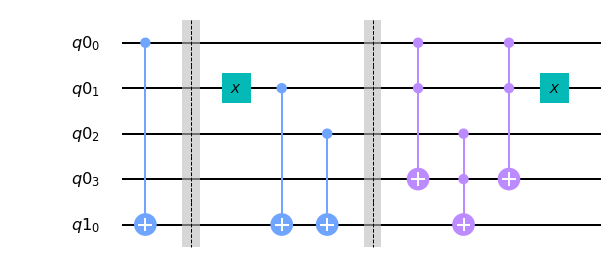

In [4]:
f_in=QuantumRegister(4)
f_out=QuantumRegister(1)
circuit=QuantumCircuit(f_in,f_out)

circuit.cx(f_in[0],f_out[0])
circuit.barrier()
circuit.x(f_in[1])
circuit.cx(f_in[1],f_out[0])
circuit.cx(f_in[2],f_out[0])
circuit.barrier()

circuit.ccx(f_in[0],f_in[1],f_in[3])
circuit.ccx(f_in[2],f_in[3],f_out[0])
circuit.ccx(f_in[0],f_in[1],f_in[3])

circuit.x(f_in[1])


circuit.draw(output='mpl')


In [5]:
def sub_oracle(circuit,f_in,f_outx,aux,clausula):
    for k in clausula:
        if k >0:
            circuit.cx(f_in[(k-1)],f_outx)
        else:
            circuit.x(f_in[(-k-1)])
            circuit.cx(f_in[(-k-1)],f_outx)
    
    circuit.ccx(f_in[0],f_in[1],aux[0])
    circuit.ccx(f_in[2],aux[0],f_outx)
    circuit.ccx(f_in[0],f_in[1],aux[0])
    
    for k in clausula:
        if k <0:
            circuit.x(f_in[(-k-1)])

In [6]:
def black_box_u_f(circuit, f_in, f_out, aux, sat_form):
    
    for (n,clausule) in enumerate(sat_form):
        sub_oracle(circuit,f_in,f_out[n],aux,clausule)
        circuit.barrier()
        
    if len(sat_form) == 3 :
        circuit.ccx(f_out[0],f_out[1],aux[0])
        circuit.ccx(f_out[2],aux[0],f_out[len(sat_form)])
        circuit.ccx(f_out[0],f_out[1],aux[0])
        
    elif len(sat_form) == 2:
         circuit.ccx(f_out[2],f_out[1],f_out[len(sat_form)])
    
    else :
        circuit.cx(f_out[0],f_out[len(sat_form)])
        
    for(n,clausule) in enumerate(sat_form): ##para dar reset aos qbits de output.
        sub_oracle(circuit,f_in,f_out[n],aux,clausule)
        circuit.barrier()


In [7]:
sat_formula = [[1,2,-3],[-1,-2,-3],[-1,2,3]]

#3 input qubits (3 literals in each clause)
f_in = QuantumRegister(3)
#1 ancilla qubit (ccx decomposition)
aux = QuantumRegister(1)
#output qubits = number of clauses + 1 (final output)
f_out = QuantumRegister(len(sat_formula)+1)

# Create circuit
qc = QuantumCircuit(f_in, aux, f_out)

# Prepare input states, x1=1, x3=1
qc.x(f_in[0])
qc.x(f_in[2])

black_box_u_f(qc, f_in, f_out, aux, sat_formula)

cr = ClassicalRegister(7)
qc.add_register(cr)


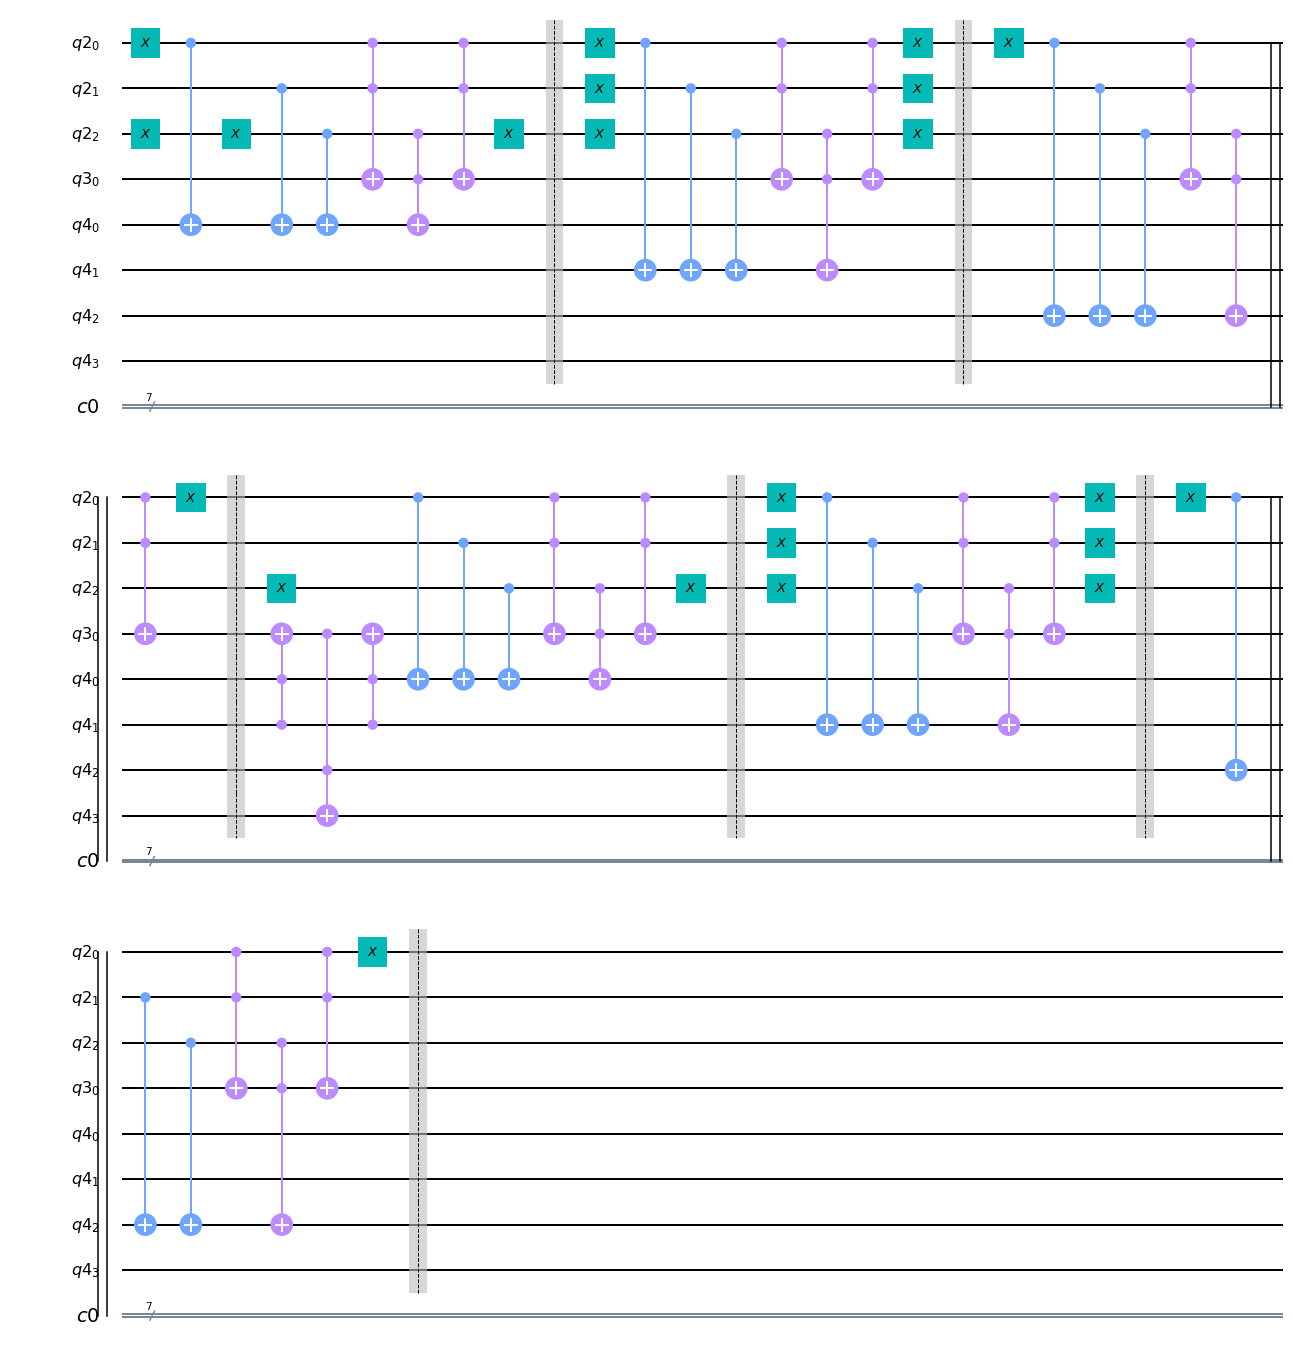

In [8]:
qc.draw(output='mpl')

## Inversion about the mean

Another important procedure in Grover search is to have an operation that perfom the *inversion-about-the-mean* step, namely, it performs the following transformation:

$$
\sum_{j=0}^{2^{n}-1} \alpha_j |j\rangle \rightarrow \sum_{j=0}^{2^{n}-1}\left(2 \left( \sum_{k=0}^{k=2^{n}-1} \frac{\alpha_k}{2^n} \right) - \alpha_j  \right) |j\rangle 
$$

The above transformation can be used to amplify the probability amplitude $\alpha_s$ when s is the solution and $\alpha_s$ is negative (and small), while $\alpha_j$ for $j \neq s$ is positive. Roughly speaking, the value of $\alpha_s$ increases by twice the mean of the amplitudes, while others are reduced. The inversion-about-the-mean can be realized with the sequence of unitary matrices as below:

$$
H^{\otimes n} \left(2|0\rangle \langle 0 | - I \right) H^{\otimes n}
$$

The first and last $H$ are just Hadamard gates applied to each qubit. The operation in the middle requires us to design a sub-circuit that flips the probability amplitude of the component of the quantum state corresponding to the all-zero binary string. The sub-circuit can be realized by the following function, which is a multi-qubit controlled-Z which flips the probability amplitude of the component of the quantum state corresponding to the all-one binary string. Applying X gates to all qubits before and after the function realizes the sub-circuit. 

In [9]:
def n_controlled_Z(circuit, controls, target):
    if(len(controls)==1):
        circuit.h(target)
        circuit.cx(controls[0],target)
        circuit.h(target)
    
    elif(len(controls)==2):
        circuit.h(target)
        circuit.ccx(controls[0],controls[1],target)
        circuit.h(target)


Finally, the inversion-about-the-mean circuit can be realized by the following function:

In [10]:
def inversion_about_mean(circuit, f_in):
    circuit.h(f_in)
    circuit.x(f_in)
    circuit.h(f_in[2])
    circuit.ccx(f_in[0],f_in[1],f_in[2])
    
    circuit.h(f_in)
    circuit.x(f_in)
    circuit.h(f_in[2])


Here is a circuit of the inversion about the mean on three qubits.

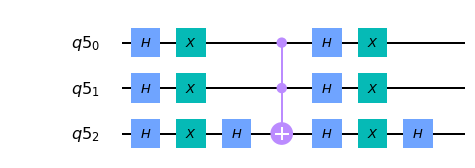

In [11]:
qr = QuantumRegister(3)
qInvAvg = QuantumCircuit(qr)
inversion_about_mean(qInvAvg, qr)
qInvAvg.draw(output='mpl')

## Grover Search: putting all together

The complete steps of Grover search is as follow.

1. Create the superposition of all possible solutions as the initial state (with working qubits initialized to zero)
$$  \sum_{j=0}^{2^{n}-1} \frac{1}{2^n} |j\rangle |0\rangle$$
2. Repeat for $T$ times:

     * Apply the `blackbox` function
    
     * Apply the `inversion-about-the-mean` function
    
3. Measure to obtain the solution

The code for the above steps is as below:

In [12]:
def grover_3sat(sat_form):
    k=len(sat_form)
    f_in= QuantumRegister(3)
    f_out = QuantumRegister(k+1)
    aux=QuantumRegister(k+1)
    cr=ClassicalRegister(3)
    grover=QuantumCircuit(f_in,aux,f_out,cr)
    iterations=2
    input_state(grover,f_in,f_out[k])
    for i in range(iterations):
        black_box_u_f(grover,f_in,f_out,aux,sat_form)
        inversion_about_mean(grover,f_in)
    grover.measure(f_in,cr)
    execute_locally(grover)

simulation: 

 Result(backend_name='qasm_simulator', backend_version='0.4.1', date=datetime.datetime(2020, 3, 23, 15, 37, 49, 299535), header=Obj(backend_name='qasm_simulator', backend_version='0.4.1'), job_id='772cea14-01b8-4dc6-b2b7-907afb0ded62', metadata={'max_memory_mb': 8174, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken': 0.0116319}, qobj_id='64c9a9e9-aee6-4419-ae3e-47fb01245f2e', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=72, 0x1=8, 0x2=6, 0x3=85, 0x4=65, 0x5=656, 0x6=68, 0x7=64)), header=Obj(clbit_labels=[['c1', 0], ['c1', 1], ['c1', 2]], creg_sizes=[['c1', 3]], memory_slots=3, n_qubits=11, name='circuit3', qreg_sizes=[['q6', 3], ['q8', 4], ['q7', 4]], qubit_labels=[['q6', 0], ['q6', 1], ['q6', 2], ['q8', 0], ['q8', 1], ['q8', 2], ['q8', 3], ['q7', 0], ['q7', 1], ['q7', 2], ['q7', 3]]), meas_level=<MeasLevel.CLASSIFIED: 2>, metadata={'measure_sampling': True, 'method': 'statevector', 'parallel_shots': 1, 'parallel_state_update': 8}, seed_s

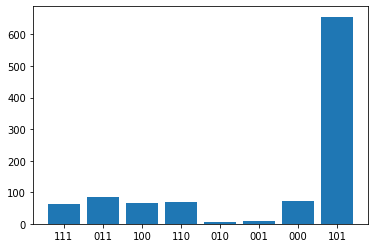

In [13]:
sat_form = [[1,2,-3],[-1,-2,-3],[-1,2,3]]
grover_3sat(sat_form)

In [14]:
circuit.cx(f_out[0],f_out[len(sat_form)])
def stairWay(controls,target,n):
    
    aux = QuantumRegister(n-2)
    qcirc = QuantumCircuit(controls,aux,target)
    
    for i in range(2):
        qcirc.ccx(controls[n-1],aux[len(aux)-1],target[0])
        
        counter = n-2
        i=len(aux)-2
        j=len(aux)-1
        while counter > 1 :
            qcirc.ccx(controls[counter],aux[i],aux[j])
            if counter == 2:
                break
            counter-=1
            j-=1
            i-=1
        
        qcirc.ccx(controls[0],controls[1],aux[0])
      
        while counter < n-1 :
            qcirc.ccx(controls[counter],aux[i],aux[j])
            counter+=1
            i+=1
            j+=1
        
    return qcirc
        
n=7
controls = QuantumRegister(n)
target = QuantumRegister(1)

circ = stairWay(controls,target,n)

circ.draw(output="mpl")

CircuitError: 'register not in this circuit'

In [15]:
def stp(control,target,n):
    
    aux = QuantumRegister(n-1)
    i=2
    j=0
    c=0
    
    qcirc1 = QuantumCircuit(control,aux,target)
    qcirc1.ccx(control[0],control[1],aux[0])
    
    for c in range(0,n-2):
        qcirc1.ccx(control[i],aux[j],aux[j+1])
        i+=1
        j+=1
        c+=1
    qcirc1.cx(aux[j],target[0])
    i-=1
    j-=1   
    while c>0:
        qcirc1.ccx(control[i],aux[j],aux[j+1])
        i-=1
        j-=1
        c-=1
    qcirc1.ccx(control[0],control[1],aux[0])

    return qcirc1

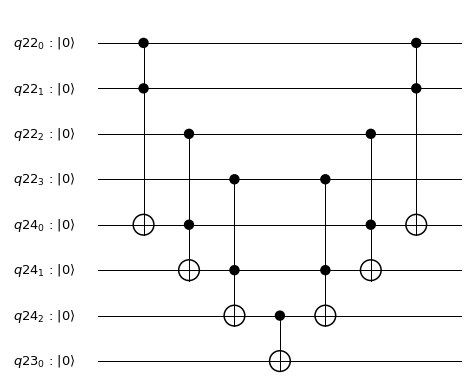

In [29]:

n=4
control = QuantumRegister(n)
target = QuantumRegister(1)

circ1 = stp(control,target,n)

circ1.draw(output="mpl")


## Running the circuit in real devices

We have seen that the simulator can find the solution to the combinatorial problem. We would like to see what happens if we use the real quantum devices that have noise and imperfect gates. 

However, due to the restriction on the length of strings that can be sent over the network to the real devices (there are more than sixty thousands charactes of QASM of the circuit), at the moment the above circuit cannot be run on real-device backends. We can see the compiled QASM on real-device `ibmqx5` backend as follows.

In [ ]:
IBMQ.load_accounts()

In [ ]:
controls[0]# get ibmq_16_rueschlikon configuration and coupling map
backend = IBMQ.get_backend('ibmq_16_melbourne')
backend_config = backend.configuration()
backend_coupling = backend_config['coupling_map']

# compile the circuit for ibmq_16_rueschlikon
grover_compiled = compile(grover, backend=backend, coupling_map=backend_coupling, seed=1)
controls[0]
grover_compiled_qasm = grover_compiled.experiments[0].header.compiled_circuit_qasm
print("Number of gates for", backend.name(), "is", len(grover_compiled_qasm.split("\n")) - 4)

The number of gates is in the order of thousands which is above the limits of decoherence time of the current near-term quantum computers. It is a challenge to design a quantum circuit for Grover search to solve large optimization problems. 

### Free flow

In addition to using too many gates, the circuit in this notebook uses auxiliary qubits. It is left as future work to improve the efficiency of the circuit as to make it possible to run it in the real devices. Below is the original circuit. 

In [173]:
circuit_drawer(grover)

NameError: name 'grover' is not defined

## References

[1] "[A fast quantum mechanical algorithm for database search](https://arxiv.org/abs/quant-ph/9605043)", L. K. Grover, Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (STOC 1996)

[2] "[Tight bounds on quantum searching](https://arxiv.org/abs/quant-ph/9605034)", Boyer et al., Fortsch.Phys.46:493-506,1998